In [2]:
from utils import load_dtrajs_from_npz

In [3]:
raw_dtrajs_abl = load_dtrajs_from_npz('dtrajs/abl_11400_2000_dtrajs.npz')
raw_dtrajs_src = load_dtrajs_from_npz('dtrajs/src_11401_2000_dtrajs.npz')

In [4]:
def trim_dtrajs(dtrajs,length_to_discard=10,min_length=100):
   ''' Ignore trajectories under a specified length, and discard
   the initial frames of the remainder.

   Parameters
   ----------
   dtrajs : list of arrays

   length_to_discard : int, optional
   min_length : int, optional

   Returns
   -------
   trimmed : list of arrays
   '''
   trimmed = [traj[length_to_discard:] for traj in dtrajs if len(traj)>length_to_discard]
   return trimmed

In [5]:
dtrajs_abl = trim_dtrajs(raw_dtrajs_abl)
dtrajs_src = trim_dtrajs(raw_dtrajs_src)

In [6]:
import numpy as np
import mdtraj as md
from pyemma import msm
import pyemma.plots as mplt
import matplotlib.pyplot as plt
import numpy.random as npr
plt.rc('font',family='serif')
%matplotlib inline

In [7]:
import msmbuilder
import msmbuilder.msm
lag_frames = 40
ergodic_cutoff_in_frames=20
ergodic_cutoff = 1.0*ergodic_cutoff_in_frames/lag_frames

In [8]:
mb_msm_abl = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_abl.fit(dtrajs_abl)
print(mb_msm_abl.summarize())

MSM contains 1430 strongly connected components above weight=0.50. Component 178 selected, with population 72.095405%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 338
Number of nonzero entries in counts matrix : 6216 (5.44098595988%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.1
    Mean   : 2.2
    3rd Qu.: 0.5
    Max.   : 1487.5

Total transition counts :
    13631.35 counts
Total transition counts / lag_time:
    340.78375 units
Timescales:
    [2169.54, 1907.65, 1858.34, 1800.73, 1659.07, 1590.01, 1542.29, 1477.60, 1345.10, 1332.19, 1191.67, 1156.80, 1068.17, 982.33, 933.27, 815.23, 752.10, 700.40, 695.71, 647.44, 637.63, 629.52, 600.83, 540.80, 534.18, 532.25, 529.38, 506.88, 501.71, 420.72, 402.92, 399.72, 398.36, 386.80, 382.91, 381.67, 379.46, 372.06, 366.12, 364.78, 362.00, 356.31, 339.54, 328.00, 324.58, 324.00, 315.33, 300.18, 295.68, 285

In [9]:
mb_msm_src = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_src.fit(dtrajs_src)
print(mb_msm_src.summarize())

MSM contains 1789 strongly connected components above weight=0.50. Component 49 selected, with population 23.611457%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 52
Number of nonzero entries in counts matrix : 1153 (42.6405325444%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.2
    Mean   : 0.9
    3rd Qu.: 0.7
    Max.   : 61.7

Total transition counts :
    991.9 counts
Total transition counts / lag_time:
    24.7975 units
Timescales:
    [2308.10, 1141.29, 346.74, 293.34, 258.27, 200.46, 168.38, 152.31, 97.69, 92.18, 55.69, 52.05, 47.25, 40.30, 36.65, 36.12, 34.67, 34.10, 33.49, 32.46, 31.89, 30.82, 29.98, 29.23, 28.68, 27.99, 27.18, 26.23, 25.63, 24.72, 24.21, 23.79, 23.23, 22.49, 22.08, 21.65, 21.46, 21.01, 20.38, 19.89, 19.03, 18.70, 16.98, 15.40, 15.14, 14.36, 12.20, nan, nan, nan, nan]  units



In [10]:
def plot_relative_free_energies(stationary_distribution,model_name,top_k=50):
   ''' Use stationary distribution to compute the relative
   free energies of the top-k most stable states.

   Parameters
   ----------
   stationary_distribution : array-like
      vector of probabilities
   model_name : string
   top_k : int
   '''
   f_i = -np.log(sorted(stationary_distribution))[::-1];
   f_i -= f_i.min();
   plt.figure()
   plt.plot(f_i[:top_k], '.')
   plt.ylabel(r'Relative free energy ($k_B T \ln \pi_i$)')
   plt.xlabel('State index ($i$)')
   plt.title(model_name)

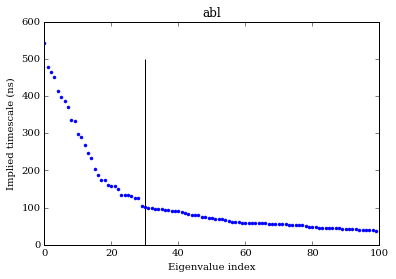

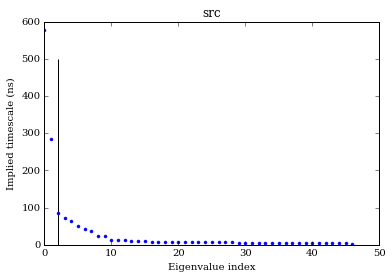

In [11]:
k=100
convert_to_ns = lambda x:x/4.0

def plot_its(msm,k):
    plt.figure()
    plt.plot(convert_to_ns(msm.timescales_[:k]),'.')
    plt.xlabel('Eigenvalue index')
    plt.ylabel('Implied timescale (ns)')


plot_its(mb_msm_abl,k) # cut at 8
plt.vlines(30,0,500)
plt.title('abl')

plot_its(mb_msm_src,k) # cut at 2?
plt.vlines(2,0,500)
plt.title('src')

In [12]:
# select number of macrostates by how many processes are slower than a threshold
ns_threshold=100

n_macro_abl=sum(convert_to_ns(mb_msm_abl.timescales_[:k])>ns_threshold)
n_macro_src=sum(convert_to_ns(mb_msm_src.timescales_[:k])>ns_threshold)
n_macro_abl,n_macro_src

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


(31, 2)

"The free energy of metastable state $S_j$ is just $f_j = - ln \sum_{i \in S_j} \pi_i$, where $\pi_i$ is the microstate equilibrium probability"

# macrostates more metastable than 6kB T: 20
Optimization terminated successfully.
         Current function value: -8.316601
         Iterations: 8
         Function evaluations: 663
# macrostates more metastable than 6kB T: 9


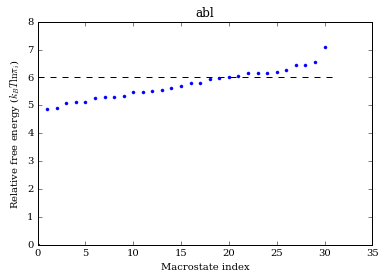

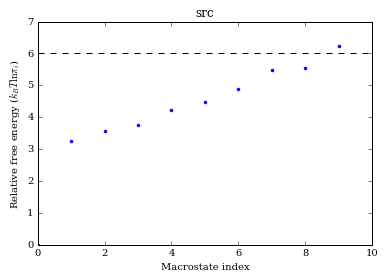

In [13]:
# compute coarse-graining by PCCA+
from msmbuilder import lumping

def coarse_grain_and_plot_energies(msm_obj,n_macro,title,kt_threshold=6):
    pcca = lumping.PCCAPlus.from_msm(msm_obj, n_macrostates=n_macro)
    n_micro=len(pcca.microstate_mapping_)

    # each element of this array is a list of microstate indices corresponding to macrostate indices
    microstates_per_macrostate = np.array([np.arange(n_micro)[pcca.microstate_mapping_==i] for i in range(n_macro)])

    # compute and sort relative macrostate free energies
    macrostate_free_energies = np.array([-np.log(np.sum([msm_obj.populations_[i] for i in microstates])) for microstates in microstates_per_macrostate])
    macrostate_free_energies -= macrostate_free_energies.min()
    macrostate_free_energies = np.array(sorted(macrostate_free_energies))

    # plot, with a threshold of 6kT
    plt.plot(macrostate_free_energies,'.')
    plt.xlabel('Macrostate index')
    plt.ylabel(r'Relative free energy ($k_B T \ln \pi_i$)')
    plt.title(title)
    plt.hlines(kt_threshold,0,n_macro,linestyles='--')

    print('# macrostates more metastable than {0}kB T: {1}'.format(kt_threshold,
                                                                   sum(macrostate_free_energies<kt_threshold)))
    return pcca


pcca_abl = coarse_grain_and_plot_energies(mb_msm_abl,n_macro_abl,'abl')
plt.figure()
pcca_src = coarse_grain_and_plot_energies(mb_msm_src,10,'src')

In [14]:
pcca = pcca_abl
n_macro=31
n_micro=338
microstates_per_macrostate = np.array([np.arange(n_micro)[pcca.microstate_mapping_==i] for i in range(n_macro)])

# compute and sort relative macrostate free energies
macrostate_free_energies = np.array([-np.log(np.sum([mb_msm_abl.populations_[i] for i in microstates])) for microstates in microstates_per_macrostate])
macrostate_free_energies -= macrostate_free_energies.min()

In [15]:
pcca_abl.microstate_mapping_

array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30,  4, 30, 30, 16, 23, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 20,
       30, 30, 30, 23, 30, 30, 30, 30, 24, 30, 30, 30, 30, 30, 30, 30, 11,
       30, 30, 18, 29, 30, 30, 30, 30, 30, 25, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 24, 30, 30, 30, 30, 30, 30, 23, 30, 30, 30, 26, 17, 30,
       13, 30, 10, 29, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,  6, 30, 30,
       30, 30, 17, 28, 30, 30, 30, 30, 30, 30, 30, 11, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 17, 30, 17, 30, 30, 30, 30, 30, 30, 14, 30, 30, 30,
       30, 30, 30, 14, 30, 30, 13,  1, 10, 30, 30, 30, 30, 30, 30, 30,  2,
        8, 30, 16, 30, 30, 30, 30, 30, 30, 29, 30, 30, 30,  9, 30, 30, 16,
       30, 30, 16, 30, 30, 17, 16, 30, 30, 30, 20, 30, 15, 30, 30, 30, 29,
       30, 30, 30, 30,  1, 30, 30, 30, 30, 30, 30, 18, 30, 19, 30, 30, 30,
       30, 22, 30, 30, 27

In [ ]:
macrostate_free_energies

In [ ]:
macrostate_free_energies.max(),np.argmax(macrostate_free_energies)

In [ ]:
most_metastable_macrostate = np.argmax(macrostate_free_energies)
microstate_indices_in_most_metastable_macrostate = microstates_per_macrostate[most_metastable_macrostate]

In [ ]:
microstate_indices_in_most_metastable_macrostate

In [16]:
mb_msm_abl.mapping_

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 5: 4,
 6: 5,
 7: 6,
 9: 7,
 10: 8,
 11: 9,
 14: 10,
 18: 11,
 19: 12,
 23: 13,
 27: 14,
 29: 15,
 33: 16,
 34: 17,
 39: 18,
 40: 19,
 43: 20,
 46: 21,
 51: 22,
 52: 23,
 55: 24,
 60: 25,
 67: 26,
 78: 27,
 86: 28,
 109: 29,
 110: 30,
 119: 31,
 122: 32,
 131: 33,
 136: 34,
 138: 35,
 139: 36,
 140: 37,
 146: 38,
 152: 39,
 168: 40,
 177: 41,
 198: 42,
 201: 43,
 208: 44,
 216: 45,
 224: 46,
 230: 47,
 240: 48,
 244: 49,
 246: 50,
 248: 51,
 273: 52,
 285: 53,
 304: 54,
 313: 55,
 316: 56,
 317: 57,
 319: 58,
 338: 59,
 353: 60,
 370: 61,
 374: 62,
 378: 63,
 401: 64,
 403: 65,
 411: 66,
 412: 67,
 425: 68,
 426: 69,
 434: 70,
 437: 71,
 439: 72,
 445: 73,
 450: 74,
 468: 75,
 469: 76,
 481: 77,
 483: 78,
 484: 79,
 485: 80,
 492: 81,
 503: 82,
 505: 83,
 506: 84,
 507: 85,
 525: 86,
 526: 87,
 527: 88,
 531: 89,
 535: 90,
 548: 91,
 556: 92,
 568: 93,
 570: 94,
 575: 95,
 577: 96,
 595: 97,
 637: 98,
 653: 99,
 677: 100,
 678: 101,
 694: 102,
 699: 103,
 70

In [ ]:
inv_map = {micro: cluster for cluster, micro in mb_msm_abl.mapping_.items()}

In [ ]:
cluster_ids_in_metastable_state = [inv_map[i] for i in microstate_indices_in_most_metastable_macrostate]
cluster_ids_in_metastable_state

In [19]:
# create a length-2000 array and save it, mapping each cluster_id to 
# its metastable state

macrostate_ids = np.zeros(2000)-1

for i in range(len(macrostate_ids)):
    cluster_id = i
    if cluster_id in mb_msm_abl.mapping_:
        microstate_id = mb_msm_abl.mapping_[cluster_id]
        macrostate_id = pcca_abl.microstate_mapping_[microstate_id]
        macrostate_ids[cluster_id] = macrostate_id
        
np.save('macrostate_ids_abl.npy',macrostate_ids)

In [20]:
macrostate_ids = np.zeros(2000)-1

for i in range(len(macrostate_ids)):
    cluster_id = i
    if cluster_id in mb_msm_src.mapping_:
        microstate_id = mb_msm_src.mapping_[cluster_id]
        macrostate_id = pcca_src.microstate_mapping_[microstate_id]
        macrostate_ids[cluster_id] = macrostate_id
        
np.save('macrostate_ids_src.npy',macrostate_ids)

In [18]:
macrostate_ids

array([ 30.,  30.,  30., ...,   8.,  -1.,  30.])

In [ ]:
# map 

In [ ]:
for i in cluster_ids_in_metastable_state:
    print(1.0*np.sum(np.hstack(dtrajs_abl)==i)/len(np.hstack(dtrajs_abl)))

In [ ]:
# PCCA object instructs me to transform dtrajs into coarse-grained dtrajs and fit a new markov state model
# to get coarse-grained transition matrix...
def pcca_T(pcca_obj,dtrajs):
    macrostate_dtrajs = []
    for dtraj in dtrajs:
        m_dtraj = np.zeros(len(dtraj),dtype=int)
        for i in range(len(m_dtraj)):
            m_dtraj[i] = pcca_obj.microstate_mapping_[pcca_obj.mapping_[dtraj[i]]]
        macrostate_dtrajs.append(m_dtraj)
    M = msmbuilder.msm.MarkovStateModel()
    M.fit(macrostate_dtrajs)
    T = M.transmat_
    return T

In [ ]:
# but this yields errors, since some cluster IDs are not included due to ergodic trimming
T = pcca_T(pcca_abl,dtrajs_abl)